In [ ]:
import pandas as pd

df = pd.read_csv('/content/preprocessed_train_data.csv')


# Check the distribution of the target variable (IncidentGrade)
target_distribution = df['IncidentGrade'].value_counts(normalize=True)

print("Distribution of IncidentGrade:")
print(target_distribution)

# Determine if the dataset is imbalanced
threshold = 0.1  # You can adjust this threshold as needed
if any(target_distribution < threshold):
    print("\nDataset is imbalanced. Some classes have less than 10% representation.")
else:
    print("\nDataset is relatively balanced.")


Distribution of IncidentGrade:
IncidentGrade
-1.033501    0.438289
 1.232803    0.348235
 0.099651    0.213476
Name: proportion, dtype: float64

Dataset is relatively balanced.



Top 10 Features by Importance:
       Feature  Importance
2        OrgId    0.235906
3   IncidentId    0.143143
5   DetectorId    0.108112
4      AlertId    0.097349
6   AlertTitle    0.084116
7     Category    0.043806
1           Id    0.037218
37        Hour    0.023916
36   DayOfWeek    0.022468
8   EntityType    0.022110

Least Important Features:
               Feature  Importance
24     ApplicationName    0.001824
23       ApplicationId    0.001630
20         RegistryKey    0.001154
30           OSVersion    0.000694
29            OSFamily    0.000610
28      ResourceIdName    0.000171
22   RegistryValueData    0.000071
21   RegistryValueName    0.000052
25  OAuthApplicationId    0.000037
34                Year    0.000017


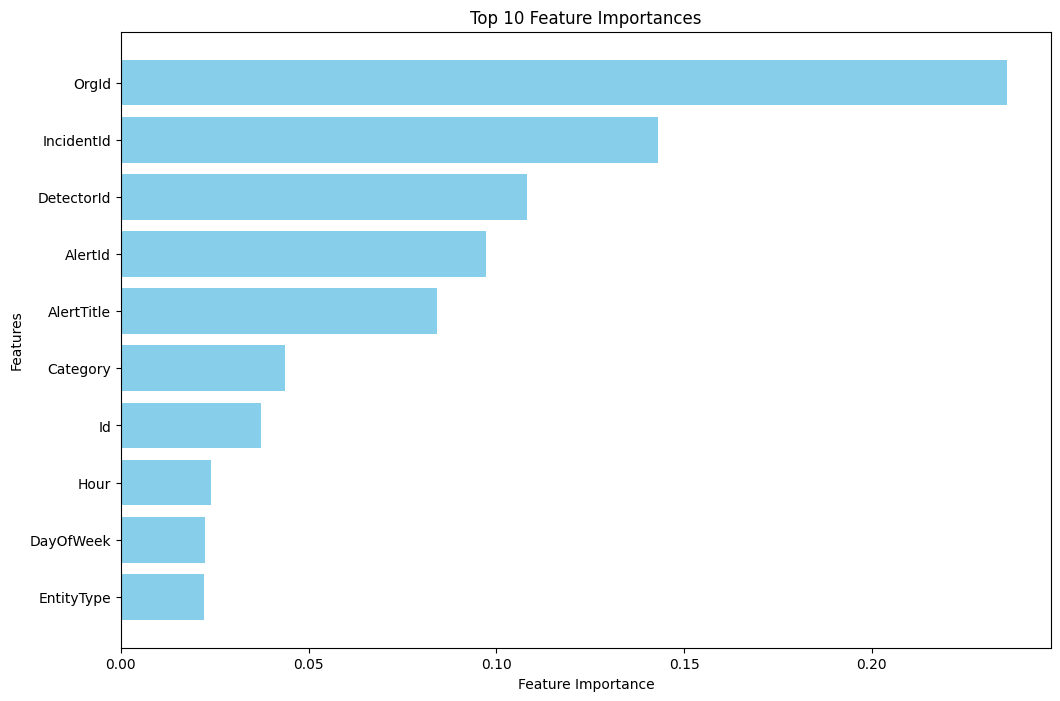

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/preprocessed_train_data.csv')
# Split features (X) and target (y)
X = df.drop(columns=["IncidentGrade"])  # Replace "IncidentGrade" with the target column name
y = df["IncidentGrade"]

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Extract feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display top and least important features
print("\nTop 10 Features by Importance:")
print(importance_df.head(10))

print("\nLeast Important Features:")
print(importance_df.tail(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances")
plt.show()


**Evaluation of Selected Random Forest Model on Test Data**



Training Random Forest with default hyperparameters...

Evaluating Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     80517
           1       0.98      0.97      0.97     44451
           2       1.00      0.97      0.98    134521

    accuracy                           0.97    259489
   macro avg       0.97      0.98      0.97    259489
weighted avg       0.98      0.97      0.97    259489


Confusion Matrix:
[[ 79667    605    245]
 [  1244  42991    216]
 [  3757    493 130271]]


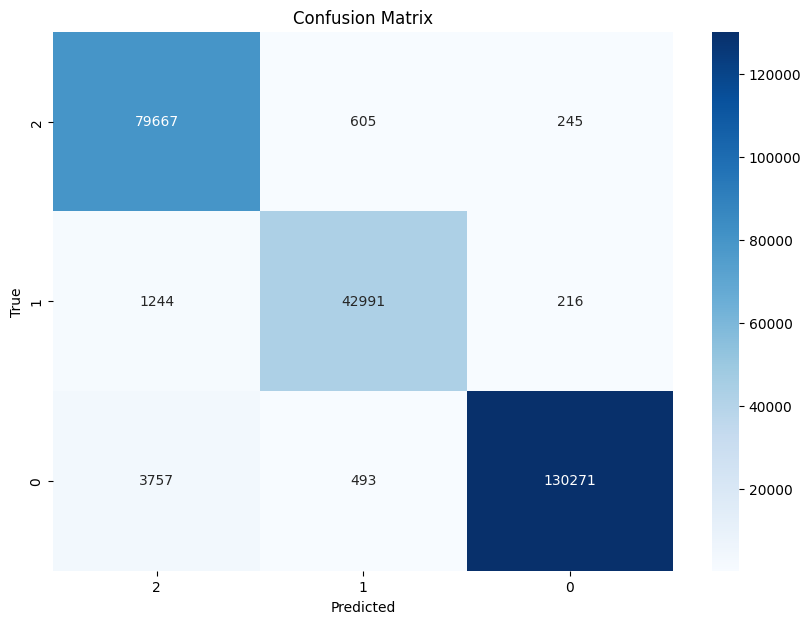


Cross-Validation F1 Scores: [0.97635335 0.97649513 0.97550003 0.97550504 0.97567972]
Mean CV F1 Score: 0.9759


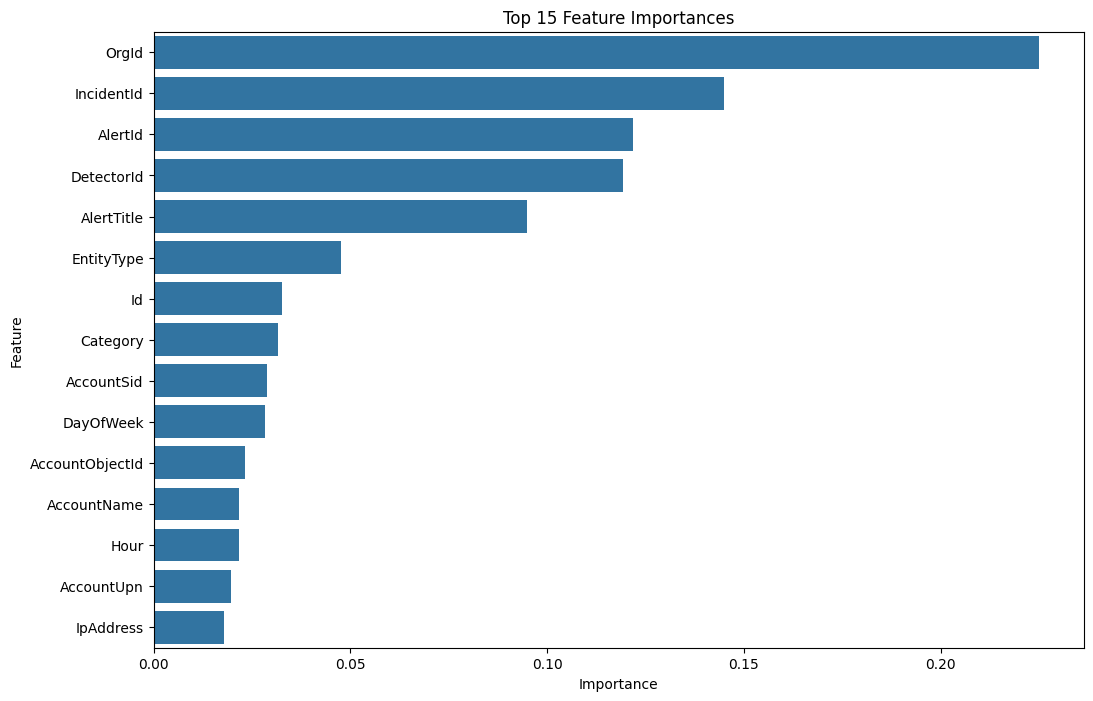

Random Forest model saved to /content/drive/MyDrive/random_forest_model_default.pkl.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/preprocessed_train_dataset.csv")


X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']


X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


categorical_columns = X_train.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()

for col in categorical_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_valid[col] = label_encoder.transform(X_valid[col])


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=['int64', 'float64']))
X_valid_scaled = scaler.transform(X_valid.select_dtypes(include=['int64', 'float64']))

X_train[X_train.select_dtypes(include=['int64', 'float64']).columns] = X_train_scaled
X_valid[X_valid.select_dtypes(include=['int64', 'float64']).columns] = X_valid_scaled

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


rf_model = RandomForestClassifier(
    n_estimators=200,  # More trees for stability
    max_depth=30,  # Reasonable depth to avoid overfitting
    min_samples_split=2,  # Prevents deep tree splits
    min_samples_leaf=1,  # Larger leaf size for better generalization
    max_features=None,  # Optimized feature selection
    bootstrap=True,  # Boostrap sampling
    class_weight='balanced',  # Handles class imbalance
    random_state=42
)


print("\nTraining Random Forest with default hyperparameters...")
rf_model.fit(X_train_resampled, y_train_resampled)


print("\nEvaluating Random Forest...")
y_pred = rf_model.predict(X_valid)

# Metrics
precision = precision_score(y_valid, y_pred, average='macro')
recall = recall_score(y_valid, y_pred, average='macro')
f1 = f1_score(y_valid, y_pred, average='macro')

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_valid, y_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['IncidentGrade'].unique(), yticklabels=df['IncidentGrade'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


cv_scores = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f}")


feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

# Save the model to Google Drive
model_path = "/content/drive/MyDrive/random_forest_model_default.pkl"
with open(model_path, "wb") as file:
    pickle.dump(rf_model, file)
print(f"Random Forest model saved to {model_path}.")


Model loaded successfully!


<ipython-input-6-0ea18f8b6ebf>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = label_encoder.fit_transform(X_test[col])
<ipython-input-6-0ea18f8b6ebf>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_columns] = scaler.fit_transform(X_test[numeric_columns])



Evaluating Test Dataset:
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.77      0.59    262210
           1       0.44      0.68      0.53    186039
           2       0.93      0.52      0.67    613447

    accuracy                           0.61   1061696
   macro avg       0.61      0.66      0.59   1061696
weighted avg       0.73      0.61      0.62   1061696


Macro F1 Score on Test Data: 0.5942
Confusion Matrix on Test Data:
[[201920  49834  10456]
 [ 44394 126767  14878]
 [180484 114558 318405]]


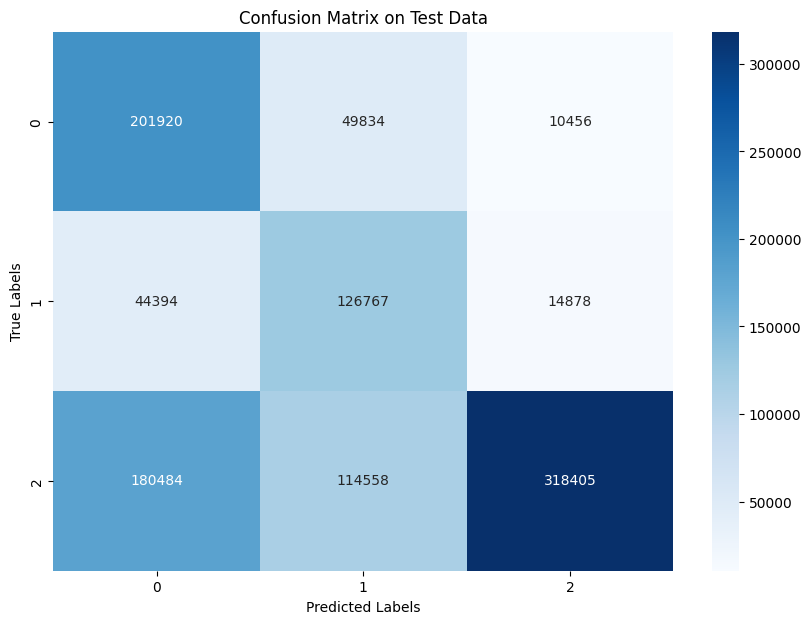


F1 Score (Train): 0.9789
F1 Score (Test): 0.5942
Difference (Train - Test): 0.3847


In [ ]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

model_path = "/content/drive/MyDrive/random_forest_model_default.pkl"
with open(model_path, "rb") as file:
    trained_model = pickle.load(file)
print("Model loaded successfully!")

test_df = pd.read_csv("/content/drive/MyDrive/preprocessed_test_dataset.csv")



expected_columns = [
    'Unnamed: 0', 'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId',
    'AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DeviceId',
    'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
    'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData',
    'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
    'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily',
    'OSVersion', 'CountryCode', 'Year', 'Month', 'DayOfWeek', 'Hour',
    'State_0.0', 'City_0.0'
]

# Add missing columns to the test dataset with default values
for col in expected_columns:
    if col not in test_df.columns:
        test_df[col] = 0


X_test = test_df[expected_columns]

y_test = test_df["IncidentGrade"]


categorical_columns = X_test.select_dtypes(include=["object"]).columns
label_encoder = LabelEncoder()

for col in categorical_columns:
    X_test[col] = label_encoder.fit_transform(X_test[col])

# Step 5: Scale Numerical Columns
numeric_columns = X_test.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X_test[numeric_columns] = scaler.fit_transform(X_test[numeric_columns])


y_test_pred = trained_model.predict(X_test)

print("\nEvaluating Test Dataset:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

f1_test = f1_score(y_test, y_test_pred, average="macro")
print(f"\nMacro F1 Score on Test Data: {f1_test:.4f}")

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix on Test Data:")
print(cm_test)

# Step 7: Visualize the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=trained_model.classes_, yticklabels=trained_model.classes_)
plt.title("Confusion Matrix on Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Step 8: Compare Train and Test Performance (Optional)
f1_train = 0.9789  # Replace with your actual training F1 score
print(f"\nF1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Test): {f1_test:.4f}")
print(f"Difference (Train - Test): {f1_train - f1_test:.4f}")


In [ ]:
!nvidia-smi


Sat Dec 21 18:54:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!conda create -n rapids- -c rapidsai -c nvidia -c conda-forge -c defaults \
  python=3.8 cudatoolkit=11.2 rapids=22.12


/bin/bash: line 1: conda: command not found


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89    288062
           1       0.85      0.83      0.84    140858
           2       0.93      0.86      0.90    230304

    accuracy                           0.88    659224
   macro avg       0.88      0.87      0.88    659224
weighted avg       0.88      0.88      0.88    659224


Confusion Matrix:
[[266397  12719   8946]
 [ 18720 116318   5820]
 [ 23301   8293 198710]]


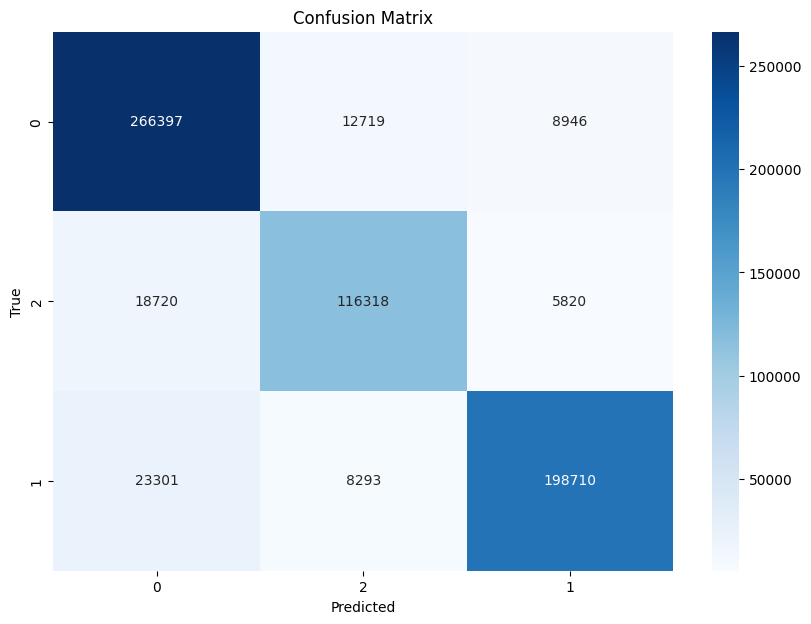


Performing Stratified Cross-Validation...

Stratified CV F1 Scores: [0.89754285 0.90470518 0.89457545 0.90296891 0.89547454]
Mean Stratified CV F1 Score: 0.8991


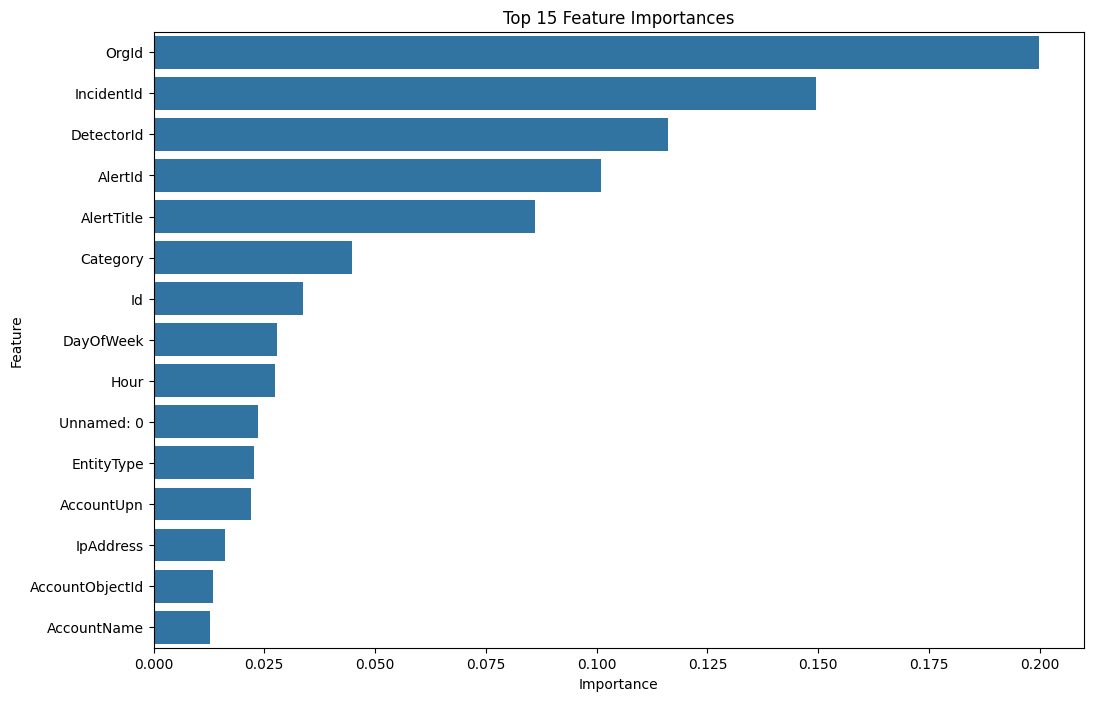

Random Forest model saved to /content/random_forest_model_fixed_params.pkl.


In [35]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load dataset
df = pd.read_csv("/content/preprocessed_train_data.csv")

# Handle missing values
df = df.dropna(subset=['IncidentGrade'])  # Drop rows with missing target values (y)
df = df.fillna(df.mean())  # Fill missing values in features with mean

# Convert 'IncidentGrade' to categorical if it's not already
df['IncidentGrade'] = df['IncidentGrade'].astype('category')

# Encode 'IncidentGrade' into integers for classification
label_encoder = LabelEncoder()
df['IncidentGrade'] = label_encoder.fit_transform(df['IncidentGrade'])

# Split features and target
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Downsampling - Use only 2% of data for training
X_train_downsampled, _, y_train_downsampled, _ = train_test_split(
    X_train, y_train, train_size=0.02, random_state=42
)

# Label encoding for categorical features
categorical_columns = X_train_downsampled.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X_train_downsampled[col] = label_encoder.fit_transform(X_train_downsampled[col])
    X_valid[col] = label_encoder.transform(X_valid[col])

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_downsampled.select_dtypes(include=['int64', 'float64']))
X_valid_scaled = scaler.transform(X_valid.select_dtypes(include=['int64', 'float64']))

X_train_downsampled[X_train_downsampled.select_dtypes(include=['int64', 'float64']).columns] = X_train_scaled
X_valid[X_valid.select_dtypes(include=['int64', 'float64']).columns] = X_valid_scaled

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_downsampled, y_train_downsampled)

# Define Random Forest model with provided hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=None,
    bootstrap=False,
    random_state=42
)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the validation set
y_valid_pred = rf_model.predict(X_valid)
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_valid, y_valid_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['IncidentGrade'].unique(), yticklabels=df['IncidentGrade'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Stratified Cross-Validation
print("\nPerforming Stratified Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    rf_model, X_train_resampled, y_train_resampled,
    cv=skf, scoring='f1_macro'
)
print(f"\nStratified CV F1 Scores: {cv_scores}")
print(f"Mean Stratified CV F1 Score: {cv_scores.mean():.4f}")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train_downsampled.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

# Save the model to file
model_path = "/content/random_forest_model_fixed_params.pkl"
with open(model_path, "wb") as file:
    pickle.dump(rf_model, file)
print(f"Random Forest model saved to {model_path}.")


In [17]:
# Save the best model to file
model_path = "/content/random_forest_model_tuned.pkl"
with open(model_path, "wb") as file:
    pickle.dump(best_rf_model, file)
print(f"Tuned Random Forest model saved to {model_path}.")

Tuned Random Forest model saved to /content/random_forest_model_tuned.pkl.


Model loaded successfully!
Columns in the test dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Usage', 'Year', 'Month', 'DayOfWeek', 'Hour'],
      dtype='object')
Encoded 'Usage' column values: [1 0]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



Evaluating Test Dataset:
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.13      0.20    788046
           1       0.32      0.31      0.32    474409
           2       0.53      0.77      0.63   1162780

    accuracy                           0.47   2425235
   macro avg       0.41      0.41      0.38   2425235
weighted avg       0.44      0.47      0.43   2425235


Macro F1 Score on Test Data: 0.3809
Confusion Matrix on Test Data:
[[105157 194120 488769]
 [ 33795 146398 294216]
 [150003 113788 898989]]


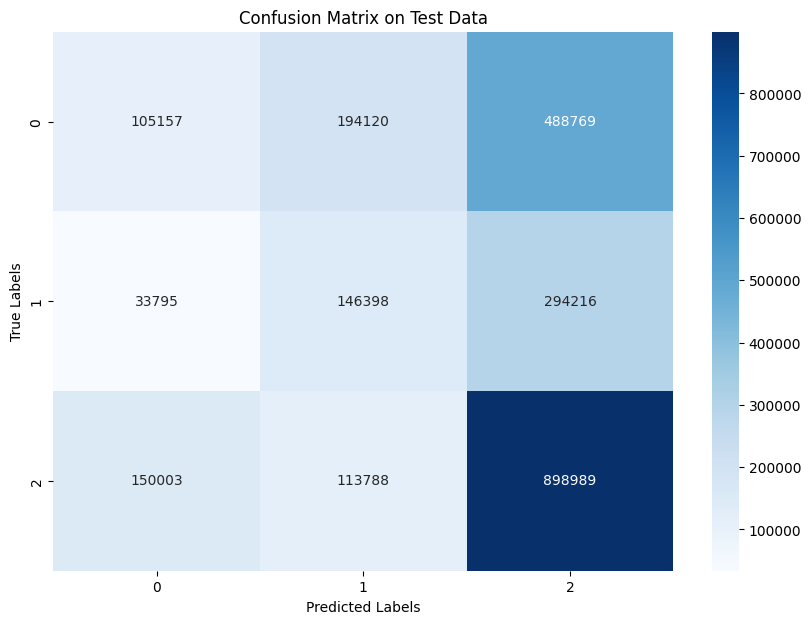


F1 Score (Train): 0.9789
F1 Score (Test): 0.3809
Difference (Train - Test): 0.5980


In [36]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model_path = "/content/random_forest_model_fixed_params.pkl"
with open(model_path, "rb") as file:
    trained_model = pickle.load(file)
print("Model loaded successfully!")

# Load the test dataset
test_df = pd.read_csv("/content/preprocessed_Test_data.csv")

# Check the columns in the test dataset
print("Columns in the test dataset:")
print(test_df.columns)

# Expected columns based on the training dataset
expected_columns = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
    'Category', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress',
    'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName',
    'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData',
    'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath',
    'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City',
    'Year', 'Month', 'DayOfWeek', 'Hour'
]

# Ensure that the columns in the test set are exactly the same as expected columns
# If 'Unnamed: 0' exists, keep it in the dataset as it was in training
if 'Unnamed: 0' in test_df.columns:
    test_df = test_df[['Unnamed: 0'] + expected_columns]  # Include 'Unnamed: 0' in the test dataset

# Additional logic for 'Usage' column encoding
if 'Usage' in test_df.columns:
    label_encoder_usage = LabelEncoder()
    test_df['Usage'] = label_encoder_usage.fit_transform(test_df['Usage'])
    print("Encoded 'Usage' column values:", test_df['Usage'].unique())

# Extract features (X) and target variable (y)
X_test = test_df.drop('IncidentGrade', axis=1)
y_test = test_df['IncidentGrade']

# Encode the target variable
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Scale the features
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Predict using the trained model
y_pred_test = trained_model.predict(X_test_scaled)

# Evaluate on the test dataset
print("\nEvaluating Test Dataset:")
print("Classification Report:")
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_test, target_names=target_names))

# Compute Macro F1 Score
f1_test = f1_score(y_test_encoded, y_pred_test, average="macro")
print(f"\nMacro F1 Score on Test Data: {f1_test:.4f}")

# Confusion Matrix
cm_test = confusion_matrix(y_test_encoded, y_pred_test)
print("Confusion Matrix on Test Data:")
print(cm_test)

# Step 7: Visualize the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix on Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Step 8: Compare Train and Test Performance (Optional)
f1_train = 0.9789  # Replace with your actual training F1 score if available
print(f"\nF1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Test): {f1_test:.4f}")
print(f"Difference (Train - Test): {f1_train - f1_test:.4f}")
